# Анализ популярности публикаций
Данный проект преслудет две смежных цели:  
- проанализировать причины популярности/непопулярности тех или иных публикаций.  
- разработать модель машинного обучения, которая будет спосбна предсказывать популярность постов.  

Сам по себе термин "популярность" - достаточно общий - в вводной части исследования употребляется не случайно. Какой именно показатель выбран в качестве метрики популярности указано [ниже](#21).



## Оглавление<a id="0"></a>

- [Подготовка](#1)   
    - [Обзор данных](#11)
- [Выбор целевого признака](#2)
    - [Синтетическая метрика](#21)
- [Предобработка](#3)
    - [Результат предобработки](#31)
    - [Текст](#32)
    - [Тэги](#33)
    - [Другие признаки](#34)
- [Разработка модели](#4)
    - [Подготовка данных](#41)
    - [Обучение модели](#42)
    - [Проверка качества модели](#43)
- [Анализ важности признаков](#5)
    - [Текст](#51)
    - [Тэги](#52)
    - [Другие сущности](#53)
- [Выводы](#6)

Здесь и далее можно скрыть/показать код, нажав соответствующую кнопку.<a id="1"></a>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
                 if (code_show){
                     $('div.input').hide();
                     } else {
                     $('div.input').show();
                 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Показать / скрыть код"></form>''')

In [2]:
# базовые библиотеки
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import scipy
import itertools
import string
import random
import os
import re
import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

from tqdm import tqdm #, tqdm_notebook, tqdm_pandas
from collections import Counter

# библиотеки для графики
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# библиотеки ML
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from statsmodels.stats.stattools import medcouple

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna.pruners import MedianPruner
from optuna.visualization import plot_optimization_history

import phik
import shap
shap.initjs()

# библиотеки предобработки и NLP
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
import emoji
import spacy
import natasha
from wordcloud import WordCloud
# from nltk.stem import WordNetLemmatizer

RS = 1008 # random state
russian_alphabet = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯабвгдеёжзийклмнопрстуфхцчшщьыъэюя-'

##### Анализ входящих данных с платформы "Телеграм"<a id="11"></a>

In [3]:
# получение имён файлов
files = os.listdir(path='data/')
vk_files_list = [vk for vk in files if vk.split('_')[0] == 'vk']
tg_files_list = [tg for tg in files if tg.split('_')[0] != 'vk']

# загрузка данных и сбор в датафрейм
data = pd.concat([pd.read_csv(f'data/{df}', index_col=0)
                  .join(pd.Series(df[3:-4],
                                  index=pd.read_csv(f'data/{df}',
                                                    index_col=0)
                                  .index, name='source_group'))
                  for df in vk_files_list]).reset_index(drop=True)

data_tg = pd.concat([pd.read_csv(f'data/{df}', index_col=0)
                  for df in tg_files_list]).reset_index(drop=True)

good_tg = data_tg[(data_tg['msg_content'] != '(File not included. Change data exporting settings to download.)') & 
                 (data_tg['reply_to_msg_id'] != -1)]

print(f"Качественных данных из Телеграмма {len(good_tg)} ({len(good_tg) / len(data_tg):.1%})")

Качественных данных из Телеграмма 75 (1.9%)


Почти все данные с платформы Телеграм в тексе сообщения содержат ошибку. Кроме того, единственный в наборе данных признак, который можно использовать как меру популярности - ответы на публикации - также отсутствует в подавляющем большинстве случаев. С учётом этого, анализ постов в Телеграмме вынесем **за рамки** исследования. При необходимости работы именно с данными из этого мессенджера, наилучшим решением будет новый сбор данных и отдельное исследование, которое можно провести на базе этого.   


##### Анализ входящих данных с платформы "VK"   

Описание данных с VK:   
- date - дата публикации   
- text - основной текст   
- is_pinned - закреплено ли сообщение   
- attachments - количество вложений   
- post_source - платформа   
- comments - количество комментариев   
- likes - количество лайков   
- reposts - количество репостов   
- views - количество просмотров   
- len_text - длинна текста (в знаках)   
- post_source_id - id источника поста   
- year - год публикации   
- month - месяц публикации   
- dayofweek - день недели   
- hour - час публикации   
- source_group - группа, в которой сделана публикация     



In [4]:
display(data.head(3))
print(data.shape)
print(data.info())

# п реобразование форматов даты
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.strftime("'%y %B")
initial_data_len = len(data)

,date,text,is_pinned,attachments,post_source,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour,source_group
0,2022-11-03 11:06:58,"Неудобно листать стену, чтобы найти мероприяти...",1.0,1.0,vk,2,6,2.0,1575.0,167,1,2022,11,3,11,artbazar_61
1,2023-02-15 10:42:46,18 февраля в 19-30\n[club8931856|СкитЪ] предст...,0.0,1.0,vk,0,20,9.0,624.0,1350,1,2023,2,2,10,artbazar_61
2,2023-02-06 13:41:00,концерт Ильи Соболева\n \n📆 16 февраля в 19:00...,0.0,1.0,vk,0,2,2.0,372.0,138,1,2023,2,0,13,artbazar_61


(15766, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15766 entries, 0 to 15765
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            15766 non-null  object 
 1   text            12402 non-null  object 
 2   is_pinned       15766 non-null  float64
 3   attachments     15766 non-null  float64
 4   post_source     15766 non-null  object 
 5   comments        15766 non-null  int64  
 6   likes           15766 non-null  int64  
 7   reposts         15766 non-null  float64
 8   views           15766 non-null  float64
 9   len_text        15766 non-null  int64  
 10  post_source_id  15766 non-null  int64  
 11  year            15766 non-null  int64  
 12  month           15766 non-null  int64  
 13  dayofweek       15766 non-null  int64  
 14  hour            15766 non-null  int64  
 15  source_group    15766 non-null  object 
dtypes: float64(4), int64(8), object(4)
memory usage: 1.9+ MB
None


Данные из VK гораздо более полные, присутствует исчерпывающее количество признаков, частично отсутствуют данные только в поле "текст" (это приемлемо в данном исследовании). Также, имеется сразу несколько признаков, которые могут быть избраны как целевые для вычисления метрики популярности.   
  

- [К оглавлению](#1) 

## Выбор целевого признака<a id="2"></a>

In [5]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Показать / скрыть код"></form>''')

Среди признаков, которые могут быть выбраны как целевые - лайки, репосты, комментарии и просмотры. Все они не являются изначальными признаками публикации, и генерируются в процессе потребления контента пользователями.

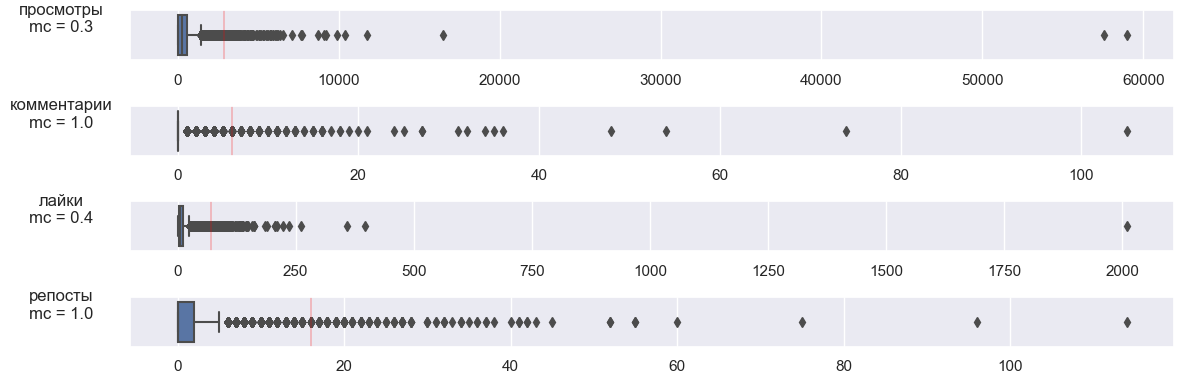

In [6]:
target_names = ['views', 'comments', 'likes', 'reposts']
target_names_rus = ['просмотры', 'комментарии', 'лайки', 'репосты']

fig, ax = plt.subplots(4, 1, figsize=(12, 4))

for position, column, rus_name in zip(itertools.product(range(4)),
                            target_names, target_names_rus):
    if column == 'views':
        dt = data[data['views'] >= 0]
    else:
        dt = data
        
    sns.boxplot(x=dt[column], orient='h',
#                 whis=[1, 99],
                ax=ax[position])
    plt.sca(ax[position])
    mc = str(np.round(medcouple(dt[column]), 1))
    plt.ylabel(rus_name + f'\nmc = {mc}',
               rotation=0, labelpad=40)
    plt.xlabel('')
    plt.axvline(dt[column].quantile(.99), c='red', linewidth=.3)

plt.tight_layout()
plt.show()
plt.close()

На диаграмме размаха видно, что данные сильно скошены вправо. На это же указывает величина mc (medcouple). Выбросы, которые можно наблюдать, не являются ошибкой и имеют место быть - это реальные посты. Однако, понимание их популярности выходит за рамки разрабатываемой модели. Чтобы выбросы не сместили её оценку, они удалены в рамках последующей предобработки.   

Распределение признаков во времени: 

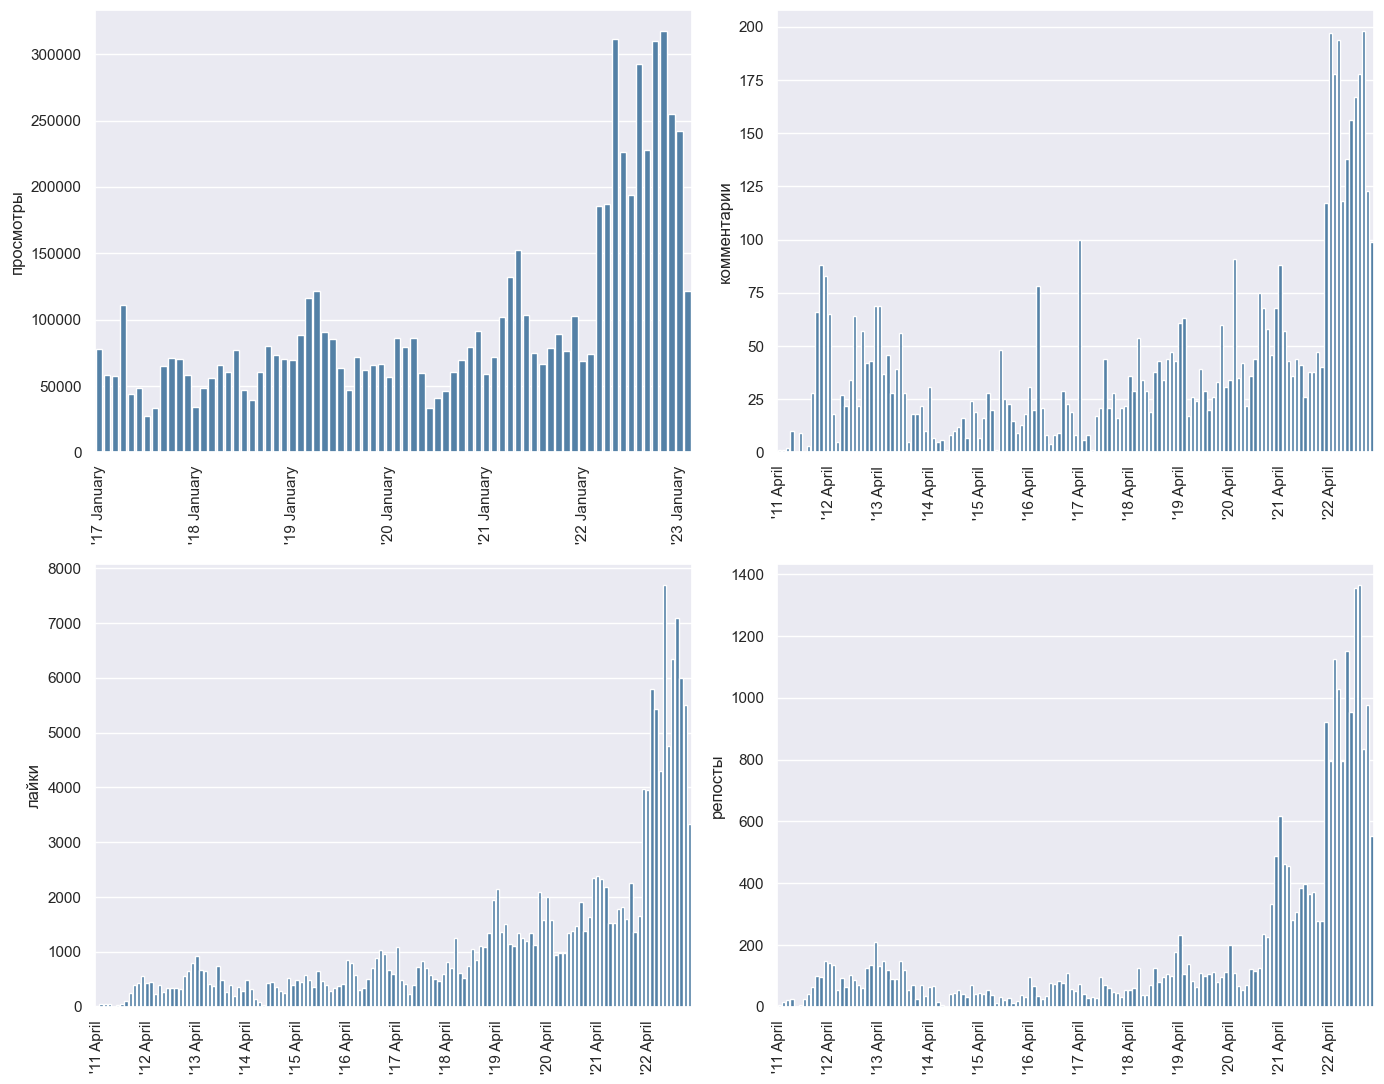

In [7]:
def target_ft_date_agg(target, method='sum', data=data):
    aggregated_data = (pd.DataFrame(
                    {'month': pd.date_range(start=data.date.min(),
                                            end='2023-03-01',
                                            freq='1M')
                     .strftime("'%y %B")})
                                   .merge(data.groupby('month',
                                                       as_index=False)
                                          .agg({target: 'sum', 'text': 'count'})
                                          .sort_values('month'),
                                      on='month',
                                      how='left'))
    aggregated_data['mean'] = aggregated_data[target] / aggregated_data['text']
    
    aggregated_data = aggregated_data.loc[
                np.flatnonzero(aggregated_data[target])
                    .tolist()[0]:
                    ]
    
    if method == 'sum':
        return aggregated_data[['month', target]]
    if method == 'mean':
        return aggregated_data[['month', 'mean']]
    
def date_barplot(plot_data, yaxisname='', title=''):
    fig, ax = plt.subplots(figsize=(14, 6))
    
    target_col = plot_data.columns[1]
    
    sns.barplot(plot_data.loc[
                np.flatnonzero(plot_data[target_col])
                    .tolist()[0]:
                    ],
                x='month',
                y=target_col,
                alpha=.7,
                color='steelblue')

    t = plt.xticks()
    plt.xticks(t[0][0::6], t[1][0::6], rotation=90)
    plt.xlabel('')
    plt.ylabel(yaxisname)
    plt.title(title)
    plt.show()
    plt.close()

fig, ax = plt.subplots(2, 2, figsize=(14, 11))

for position, column, yaxisname in zip(itertools.product(range(2), range(2)),
                            target_names, target_names_rus):
    dt = target_ft_date_agg(column)
    sns.barplot(dt, x='month', y=column,
                 color = 'steelblue', 
                ax=ax[position])
    plt.sca(ax[position])
    t = plt.xticks()
    plt.xticks(t[0][0::12], t[1][0::12], rotation=90)
    plt.xlabel('')
    plt.ylabel(yaxisname)
    
plt.tight_layout()
plt.show()
plt.close()      

Можно заметить всплеск наблюдений всех потенциально целевых признаков в последние два года. Однако, важно не забывать, что все они связаны с количеством просмотров (чем больше просмотров, тем -закономерно- в среднем, больше лайков, репостов и комментариев). Количество просмотров, в свою очередь - следствие как более активной работы по продивжению так и, непосредственно, увеличения числа публикаций.    
Также, необходимо отметить, что полноценные счётчики просмотров VK внедроили только в 2017 г., что отображено на графике.  

Выберем наиболее показательную метрику:
- `комментарии` - даже в пиковое время количество комметариев в месяц не превышает 200. Для многих постов комментарии отсутствуют, но это не нелает эти публикации плохими. Кроме того, комментарии могут быть негативными. При условии, если бы комментарии сопровождали каждый или почти каждый пост, популярность публикаций можно было бы оценивать, проводя сантиментный анализ комментариев. Однако, в данных условиях, а так же с учётом, что комментарии не выгрежены для изучения - это не приоритетная задача.    


- `репосты` - неактуальная метрика. Репосты, безусловно, имеют важное значение для продвижения, однако причины по которым их делают пользователи, далеки от исследования популярности. Например, репост может сделать сотрудничающая группа или организация - исключительно в партнёрских целях.   


- `лайки` - измерение количества лайков, как мера популярности публикации даёт эффект наиболее близкий к желаемому. Однако, показатели в 100 лайков в группе с 1 тыс. пользователей и в группе со 100 тыс. пользователей имеют принципиальное различие.  


- `просмотры` - показатель, рост или снижение которого, не связаны напрямую с качеством публикации. Например, просмотров может быть больше, если пост размещён утром, так как впереди целый день пользовательской активности. И, куда более важно, что просмотры - это не итоговый показатель, их количество может увеличиваться с течением длительного времени, даже спустя год или два.  


##### Синтетическая метрика<a id="21"></a>
Правильным решением, в данной ситуации, будет измерение конверсии просмотров в лайки.

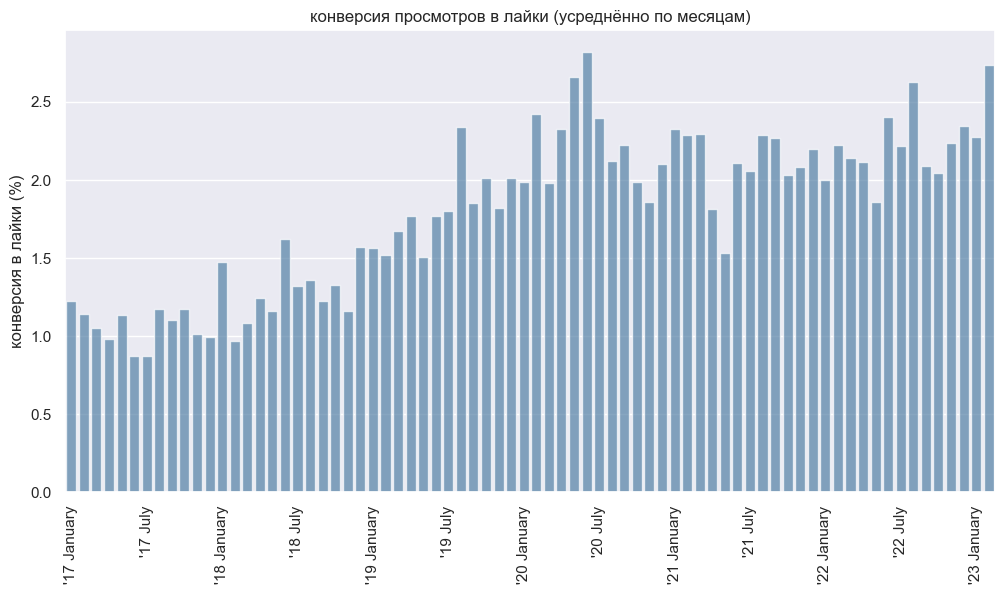

In [8]:
likes_p_views = (pd.DataFrame({'month': pd.date_range(start=data.date.min(),
                                            end='2023-03-01',
                                            freq='1M')
                     .strftime("'%y %B")})
                                   .merge(data.groupby('month',
                                                       as_index=False)
                                          .agg({'likes': 'sum', 'views': 'sum'})
                                          .sort_values('month'),
                                      on='month',
                                      how='left'))

likes_p_views = likes_p_views.loc[np.flatnonzero(likes_p_views['views']).tolist()[0]:]
likes_p_views['likes_per_view'] = (likes_p_views['likes'] / likes_p_views['views']) * 100

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(likes_p_views,
            x='month',
            y='likes_per_view',
            alpha=.7,
            color='steelblue')

t = plt.xticks()
plt.xticks(t[0][0::6], t[1][0::6], rotation=90)
plt.xlabel('')
plt.ylabel('конверсия в лайки (%)', rotation=90)
plt.title('конверсия просмотров в лайки (усреднённо по месяцам)')
plt.show()
plt.close()

Конверсия может быть измерена как в абсолютных единицах, так и в процентах - второй вариант нагляднее.

- (пример: *конверсия 2.34* - лайкнули 2.34% пользователей из 100% увидевших пост)

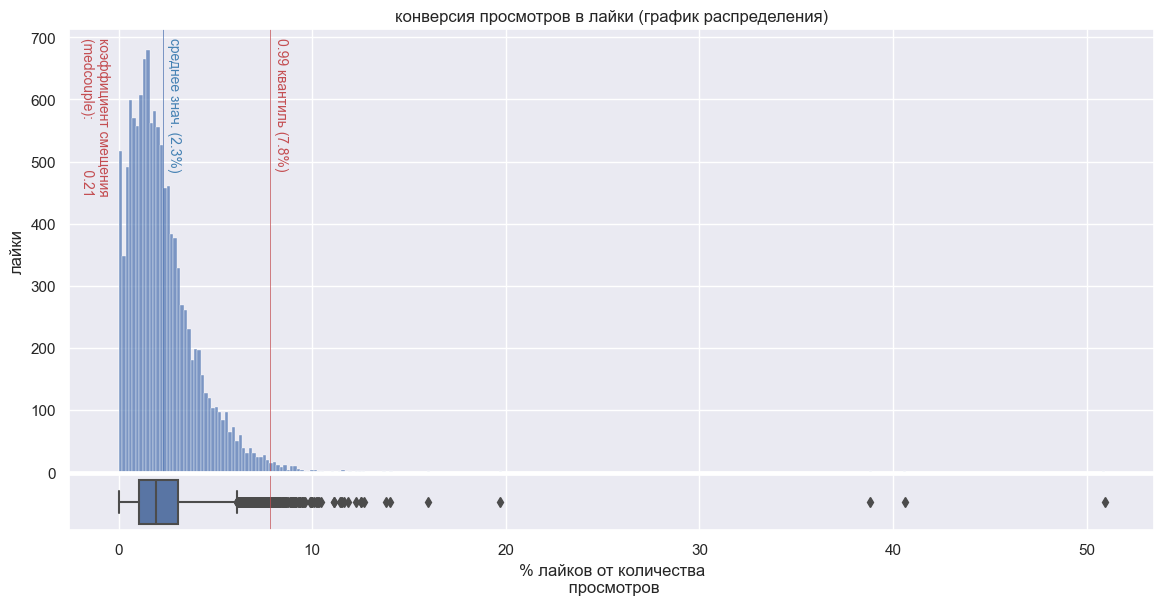

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6.5), gridspec_kw={'height_ratios': [8, 1]})

likes_p_view_hist = (data[data['views'] > 0]['likes'] / data[data['views'] > 0]['views'] * 100).tolist()

sns.histplot(x=likes_p_view_hist,
            alpha=.7, ax=ax[0])
sns.boxplot(x=likes_p_view_hist,
            orient='h',
            ax=ax[1])

plt.sca(ax[1])
plt.xlabel('% лайков от количества\n просмотров')
plt.axvline(pd.Series(likes_p_view_hist).quantile(.99), c='r', linewidth=0.5)
plt.sca(ax[0])
plt.axvline(np.mean(likes_p_view_hist), linewidth=0.5)
plt.axvline(pd.Series(likes_p_view_hist).quantile(.99), c='r', linewidth=0.5)
quant99 = pd.Series(likes_p_view_hist).quantile(.99)
quant50 = np.mean(likes_p_view_hist)
plt.text(quant99 + 0.2, 700,
         f'0.99 квантиль ({quant99:.1f}%)',
         size='small',
         verticalalignment='top',
         c='r',
         rotation=-90)
plt.text(quant50 + 0.2, 700,
         f'среднее знач. ({quant50:.1f}%)',
         size='small',
         verticalalignment='top',
         c='steelblue',
         rotation=-90)
plt.text(-2, 700,
         f'коэффициент смещения\n(medcouple):             {medcouple(likes_p_view_hist):.2f}',
         size='small',
         verticalalignment='top',
         c='r',
         rotation=-90)
plt.ylabel('лайки')
plt.title('конверсия просмотров в лайки (график распределения)')
plt.subplots_adjust(hspace = 0.01)
plt.show()
plt.close()

Синтетический целевой признак также не лишен выбросов, однако после их удаления конверсия в лайки будет наиболее показательной метрикой. Её будем предсказывать на основном треке разработки модели машинного обучения.  

⚠ Для повышения наглядности разработаем так же способ предсказания количества лайков, но уже на основе предсказанной популярности поста. Этот показатель в нашем исследовании будет вторичным.    


- [К оглавлению](#1) 

## Предобработка<a id="3"></a>

In [10]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Показать / скрыть код"></form>''')

Так как сводная метрика базируется на количестве просмотров, для анализа используем только публикации, выпущенные после 2017 года. Кроме того, убраны дубликаты, а также записи без текста и вложений одновременно.  

Предобработка признаков предполагает широкий набор использования инструментов для работы с текстовыми, категориальными и числовыми данными. Наиболее значительная её часть связана с преобразованием текста. Публикации очищены от слов, не несущих смысловой нагрузки, знаков препинания, эмодзи. Осуществлён подсчёт частей речи, тех же эмодзи, длинны сообщений и средней длинны слов, в отдельные текстовые признаки выделены именнованные сущности и включённые в публикации тэги.   

Полный список новых (дополнительных) признаков для обучения модели машинного обучения:  
- tags - тэги  
- has_link - ссылки на другие ресурсы  
- exclamations_count - подсчет восклицательных знаков (выражает эмоциональную окраску сообщения)  
- emoji_count - подсчет эмодзи (не используется)  
- emoji_rate - отношение количества эмодзи к длинне поста  
- named_entities - именованные сущности  
- tokenized - токенизированный текст (не используется)  
- natasha - служебная колонка  (не используется)  
- pos - служебная колонка  (не используется)  
- nouns - подсчет доли существительных в тексте  
- verbs - подсчет доли глаголов в тексте  
- adjectives - подсчет доли прилагательных в тексте  
- tok_without_names - токенизированный текст без именнованных сущностей и тэгов (не используется)  
- tok_without_names_unique - уникальные слова без именнованных сущностей и тэгов  
- mean_word_len - средняя длинна слова  
- named_ent_count - подсчет именованных сущносетй  
- tags_count - подсчет тэгов  
- cluster - кластер  (не используется)  

*(Некоторые признаки не используются, но присутствуют в предварительном датасете)*

In [11]:
# # # код здесь и далее закомментирован, так как не используется
# # # на заключительном этапе разработки

# emb = natasha.NewsEmbedding()
# morph_tagger = natasha.NewsMorphTagger(emb)
# morph_vocab = natasha.MorphVocab()
# segmenter = natasha.Segmenter()
# names_extr = natasha.NamesExtractor(morph_vocab)
# addr_extr = natasha.AddrExtractor(morph_vocab)
# dates_extr = natasha.DatesExtractor(morph_vocab)
# money_extr = natasha.MoneyExtractor(morph_vocab)

# # -------- cut here -----------------------------------

# # формирование датасета
# data_full = data.copy()
# data = data[data['views'] > 0]
# data = data[(data['text'].notna()) | (data['attachments'] != 0)]
# data = data[~data.duplicated(subset=data.drop(['date'], axis=1).columns)]
# data = data[data['likes'] / data['views'] < (data['likes'] / data['views']).quantile(.99)]

# # -------- cut here -----------------------------------

# # простая (начальная) предобработка
# data['text'] = data['text'].astype('str')
# data['text'] = data['text'].str.lower()
# data['text'] = data.apply(lambda x: re.sub(r"[.,:]", '', x['text']), axis=1)

# # выделение тэгов
# data['tags'] = data.apply(lambda x: re.findall(f"#[{russian_alphabet}]+", x['text']), axis=1)

# # удаление тэгов из основного текста
# data['text'] = data.apply(lambda x: ' '.join([w for w in x['text'].split(' ') if w not in x['tags']]), axis=1)

# # удаление # из тэгов, приведение тэгов к строке
# data['tags'] = data.apply(lambda x: " ".join([re.sub('#', '', word) for word in x['tags']]), axis=1)

# # подсчёт ссылок к тексте
# data['has_link'] = data.apply(lambda x: re.findall("http",x['text']), axis=1)
# data['has_link'] = [len(i) for i in data['has_link']]

# # подсчёт восклицательных знаков
# data['exclamations_count'] = data.apply(lambda x: x['text'].count('!'), axis=1)

# # подсчёт эмодзи
# data['emoji_count'] = data.apply(lambda x: sum(1 for element in
#                                             re.findall(":[A-z\\_\\-]+:",
#                                                        emoji.demojize(x['text']))), axis=1)

# # удаление некоторых топонимов
# bad_toponyms = ['владимир', '«ростов»', 'ростов', 'дон', 'таганрог', 'краснодар', 'москв', 'петербург', 'санкт']
# for word in bad_toponyms:
#     data['text'] = data.apply(lambda x: re.sub(f"{word}[\w]+ |{word}", '', x['text']), axis=1)


# # -------- cut here -----------------------------------

# # выделение именованных сущностей
# nlp = spacy.load('ru_core_news_sm')

# def get_named_entities(text):
#     doc = nlp(text)
#     named_entities = [X.text for X in doc.ents]
#     return named_entities

# data['named_entities'] = data.apply(lambda x: get_named_entities(x['text']), axis=1)
# data['named_entities'] = data.apply(lambda x: ' '.join(x['named_entities']), axis=1)

# # -------- cut here -----------------------------------

# # обработка именованных сущностей
# data['named_entities'] = data.apply(lambda x: re.sub(r"[^А-яё\-\s]+", '', x['named_entities']), axis=1)
# data['named_entities'] = data.apply(lambda x: re.sub(r" [А-яё]{0,2} |^[А-яё]{0,2} ", ' ', x['named_entities']), axis=1)
# data['named_entities'] = data.apply(lambda x: natasha.Doc(x['named_entities']), axis=1)

# # -------- cut here -----------------------------------

# # лемматизация именованных сущностей
# for doc in data['named_entities']:
#     doc.segment(segmenter)
#     doc.tag_morph(morph_tagger)
#     for token in doc.tokens:
#         token.lemmatize(morph_vocab)
# data['named_entities'] = data.apply(lambda x: [i.lemma for i in x['named_entities'].tokens], axis=1)

# # -------- cut here -----------------------------------

# # выделение уникальных именнованных сущностей
# data['named_entities'] = data.apply(lambda x: list(set(x['named_entities'])), axis=1)
# data['named_entities'] = data.apply(lambda x: ' '.join(x['named_entities']), axis=1)

# # удаление лишних пробелов
# data['named_entities'] = data.apply(lambda x: re.sub(r"[ ]+", ' ', x['named_entities']), axis=1)
# data['named_entities'] = data['named_entities'].fillna('')

# # прочее
# data['named_entities'] = data.apply(lambda x: re.sub("рф", "россия", x['named_entities']), axis=1)
# data['named_entities'] = data.apply(lambda x: re.sub('российский', 'россия', x['named_entities']), axis=1)
# data['named_entities'] = data.apply(lambda x: re.sub(r' - |^- | -$', '', x['named_entities']), axis=1)

# # -------- cut here -----------------------------------

# # основной текст

# special_chars = string.punctuation.replace('-', '') + '«»\t—…’/:'

# # токенизация текста
# data['tokenized'] = data.apply(lambda x: "".join([ch for ch in x['text']
#                                                     if ch not in special_chars]), axis=1)
# data['tokenized'] = data.apply(lambda x: re.sub(f"[^А-я- ]+", '', x['tokenized']), axis=1)
# for el in ['\n', ' - ', ' – ', '- ', ' -']:
#     data['tokenized'] = data.apply(lambda x: re.sub(el, ' ', x['tokenized']), axis=1)

# # ликвидация слов из 1-2 букв и лишних пробелов
# data['tokenized'] = data.apply(lambda x: re.sub(r" [А-яё]{0,2} |^[А-яё]{0,2} ", ' ', x['tokenized']), axis=1)
# data['tokenized'] = data.apply(lambda x: re.sub(r" [А-яё]{0,2} |^[А-яё]{0,2} ", ' ', x['tokenized']), axis=1)
# data['tokenized'] = data.apply(lambda x: re.sub(r"[ ]+", ' ', x['tokenized']), axis=1)
# data['tokenized'] = data.apply(lambda x: re.sub(r"^[ ]|[ ]$", '', x['tokenized']), axis=1)

# # -------- cut here -----------------------------------

# # расширение списка стоп-слов
# actual_stopwords = stopwords.words('russian')
# actual_stopwords.extend(['это', 'год', 'весь', 'наш', 'свой', 'который'])

# # -------- cut here -----------------------------------

# # токенизация текста
# data['natasha'] = data.apply(lambda x: natasha.Doc(x['tokenized']), axis=1)
# for doc in tqdm(data['natasha']):
#     doc.segment(segmenter)
#     doc.tag_morph(morph_tagger)
#     for token in doc.tokens:
#         token.lemmatize(morph_vocab)

# # -------- cut here -----------------------------------

# # подсчет количества основных частей речи (существительное, глагол, прилагательное)
# data['pos'] = data.apply(lambda x: [w.pos for w in x['natasha'].tokens], axis=1)
# data['nouns'] = data.apply(lambda x: len([i for i in x['pos'] if i == 'NOUN']), axis=1)
# data['verbs'] = data.apply(lambda x: len([i for i in x['pos'] if i == 'VERB']), axis=1)
# data['adjectives'] = data.apply(lambda x: len([i for i in x['pos'] if i == 'ADJ']), axis=1)

# # -------- cut here -----------------------------------

# # лемматизация текста
# data['tokenized'] = data.apply(lambda x: [w.lemma for w in x['natasha'].tokens
#                                              if w.lemma not in actual_stopwords], axis=1)
# data['tokenized'] = data.apply(lambda x: ' '.join([i for i in x['tokenized']]), axis=1)
# data['tokenized'] = data.apply(lambda x: re.sub(r' - |^- | -$', '', x['tokenized']), axis=1)

# # -------- cut here -----------------------------------

# # удаление именнованных сущностей из токенизированных текстов
# data['tok_without_names'] = data.apply(lambda x: ' '
#                                         .join([w for w in x['tokenized'].split(' ')
#                                                if w not in x['named_entities'].split(' ')]
#                                              ), axis=1)
# # удаление именнованных сущностей и дубликатов токенов из токенизированных текстов
# data['tok_without_names_unique'] = data.apply(lambda x: ' '
#                                                .join(list(set([w for w in x['tokenized'].split(' ')
#                                                                if w not in x['named_entities'].split(' ')]))
#                                                     ), axis=1)

# # -------- cut here -----------------------------------

# # дополнительная обработка (средняя длинна слов, количество имен. сущ, и тп)
# data['mean_word_len'] = data.apply(lambda x: round(np.mean([len(w) for w in x['tokenized'].split(' ')]), 1), axis=1)
# data['named_ent_count'] = data.apply(lambda x: len(x['named_entities'].split()), axis=1)
# data['tags_count'] = data.apply(lambda x: len(x['tags'].split()), axis=1)
# data['emoji_rate'] = data['emoji_count'] / data['len_text']

# # -------- cut here -----------------------------------

# # сохранение в csv
# data[['tags', 'has_link',
#        'exclamations_count', 'emoji_count', 'emoji_rate', 'named_entities', 'tokenized',
#        'natasha', 'pos', 'nouns', 'verbs', 'adjectives', 'tok_without_names',
#        'tok_without_names_unique', 'mean_word_len',
#       'named_ent_count', 'tags_count']].to_csv('all_features.csv', sep=';', index=True)

# # -------- cut here -----------------------------------

# загрузка сохранённых признаков
saved_features = pd.read_csv('all_features.csv', sep=';', index_col=0)
data = data.join(saved_features, how='right')

# заполнение пропусков в текстовых ячейках
for name in ['tags',
             'named_entities',
             'tokenized',
             'tok_without_names',
             'tok_without_names_unique']:
    data[name] = data[name].fillna('')

# дополнительная обработка (то, что не обработано ранее)
# удаление схожих тегов
substr_don = '|'.join(['донскаягосударственнаяпубличнаябиблиотека',
                        'донскойгосударственнойпубличнойбиблиотеки',
                        'донскойпубличнойбиблиотеки',
                        'донскойпубличнойбиблиотеке',
                        'донскуюпубличнуюбиблитеку',
                        'донскойпубличнойбиблиотекой'])
data['tags'] = data.apply(lambda x: re.sub(f"{substr_don}", 'донскаяпубличнаябиблиотека', x['tags']), axis=1)

# исправление has_link
data['has_link'] = data['has_link'].mask(data['has_link'] > 1, 1)

# удаление еще нескольких "лишних" слов из именованных сущностей и тэгов
unique_words = list(set(re.sub("[\s]{2,}|^\s", "",' '.join(data['tok_without_names_unique'].tolist())).split(' ')))
unique_words.extend(['как', 'арт', 'лабас'])
data['named_entities'] = data.apply(lambda x: ' '
                                    .join([w for w in x['named_entities']
                                           .split() if w not in unique_words]), axis=1)
data['tags'] = data.apply(lambda x: ' '
                                    .join([w for w in x['tags']
                                           .split() if w not in unique_words]), axis=1)

# подсчет количества частей речи
data['nouns'] = data.apply(lambda x: x['nouns'] / len(x['tokenized'].split(' ')), axis=1)
data['verbs'] = data.apply(lambda x: x['verbs'] / len(x['tokenized'].split(' ')), axis=1)
data['adjectives'] = data.apply(lambda x: x['adjectives'] / len(x['tokenized'].split(' ')), axis=1)

# загрузка результатов кластеризации признаков
data = data.join(pd.read_csv('clusters.csv', sep=';', index_col=0))
# data.to_csv('corrected_data.csv', sep=';', index=True)

##### Результат предобработки<a id="31"></a>

In [12]:
print(f"Количество наблюдений: {len(data)} ( {len(data) / initial_data_len:.2%} от первоначального )")
display(data.head(3))

Количество наблюдений: 10355 ( 65.68% от первоначального )


,date,text,is_pinned,attachments,post_source,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour,source_group,tags,has_link,exclamations_count,emoji_count,emoji_rate,named_entities,tokenized,natasha,pos,nouns,verbs,adjectives,tok_without_names,tok_without_names_unique,mean_word_len,named_ent_count,tags_count,cluster
0,2022-11-03 11:06:58,"Неудобно листать стену, чтобы найти мероприяти...",1.0,1.0,vk,2,6,2.0,1575.0,167,1,2022,'22 November,3,11,artbazar_61,,1,0,0,0.000000,,неудобный листать стена найти мероприятие конк...,Doc(text='неудобно листать стену чтобы найти м...,"['ADJ', 'VERB', 'NOUN', 'SCONJ', 'VERB', 'NOUN...",0.545455,0.272727,0.181818,неудобный листать стена найти мероприятие конк...,стена конкретный обсуждение дата найти датуафи...,8.5,0,0,0
1,2023-02-15 10:42:46,18 февраля в 19-30\n[club8931856|СкитЪ] предст...,0.0,1.0,vk,0,20,9.0,624.0,1350,1,2023,'23 February,2,10,artbazar_61,,0,3,0,0.000000,,февраль скитъ представить полный программа кон...,Doc(text='февраля скитъ представит свою полную...,"['NOUN', 'NOUN', 'VERB', 'DET', 'ADJ', 'NOUN',...",0.522124,0.115044,0.345133,февраль скитъ представить полный программа кон...,чудо жанр ряд верба представить танец соавтор ...,7.7,5,0,4
2,2023-02-06 13:41:00,концерт Ильи Соболева\n \n📆 16 февраля в 19:00...,0.0,1.0,vk,0,2,2.0,372.0,138,1,2023,'23 February,0,13,artbazar_61,,1,0,4,0.028986,,концерт илья соболев февраль пересвет-арен цел...,Doc(text='концерт ильи соболева февраля пересв...,"['NOUN', 'NOUN', 'NOUN', 'NOUN', 'ADJ', 'NOUN'...",0.750000,0.125000,0.125000,концерт февраль пересвет-арен целиноградский к...,концерт целиноградский билет купить февраль пе...,7.9,2,0,6


~ 10 тысяч наблюдений достаточно для качественного обучения модели.     


- [К оглавлению](#1) 


##### Текст<a id="32"></a>

В результате токенизации в тексте остались только слова имеющие смысловую нагрузку. Тэги и именованные сущности (имена, фамилии, названия городов, улиц, театров, музеев и т.п.) убраны в отдельные категории признаков.     
Вот как выглядит текст "в чистом виде":

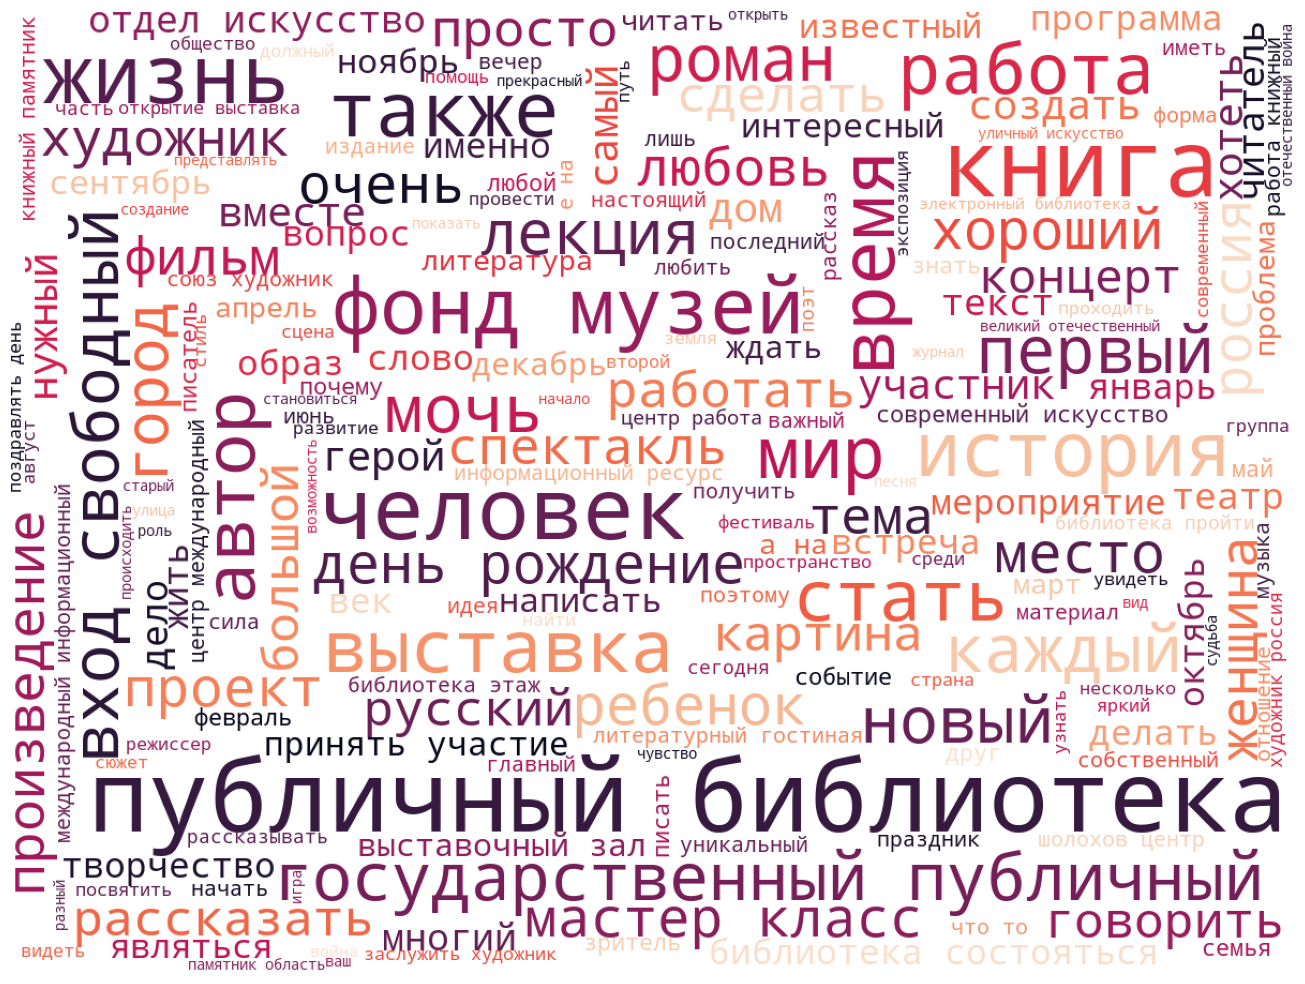

Общее количество слов: 669615
Уникальных слов: 59468


In [13]:
def word_counting(data=None,                  
                  clowd_widh=1200,
                  clowd_height=900,
                  relative_scaling='auto',
                  prefer_horizontal=0.8,
                  plot_widh=16,
                  plot_height = 10,
                  kind='wordclowd',
                  data_string=None):
    """
    data: list() или pd.Series со словами в формате 'str'
    kind: 'wordclowd' -для облака слов (wordclowd по умолчанию)
          'df' - для датафрейма с подсчётом уникальных слов
          'easy' - печать общего количества слов и количества уникальных слов
          
    clowd_widh, clowd_height - разрешение облака
    relative_scaling - пропорция количества/размера отображения одинаковых слов в облаке
    prefer_horizontal - больше или меньше горизонтально отображённых слов
    """
    if data_string == None:
        try:
            all_words = ' '.join(data.tolist())
        except: pass
    else:
        all_words = data_string
    
    if kind != 'wordclowd':
        all_words_list = all_words.split(' ')
        words_count = Counter(all_words_list)
        
        if kind == 'df':
            words_count_df = (pd.DataFrame({'word': words_count.keys(),
                                            'count': words_count.values()})
                              .sort_values('count', ascending=False)
                              .reset_index(drop=True))
            return words_count_df
        else:
            print(f"Общее количество слов: {len(all_words_list)}")
            print(f"Уникальных слов: {len(words_count)}")
            
    else:
        wordcloud = WordCloud(width=clowd_widh,
                              height=clowd_height,
                              background_color='white',
                              colormap='rocket',
                              prefer_horizontal=prefer_horizontal,
                              relative_scaling=relative_scaling,
                              random_state=RS).generate(all_words)
        plt.figure(figsize=(plot_widh, plot_height))
        plt.imshow(wordcloud)

        plt.axis("off")
        plt.tight_layout()
        plt.show()

word_counting(data['tokenized'])
word_counting(data['tokenized'], kind='easy')
# word_counting(data['tokenized'], kind='df').head(10)

⋆ чем больше слово в "облаке", тем чаще оно встречается в тексте.    

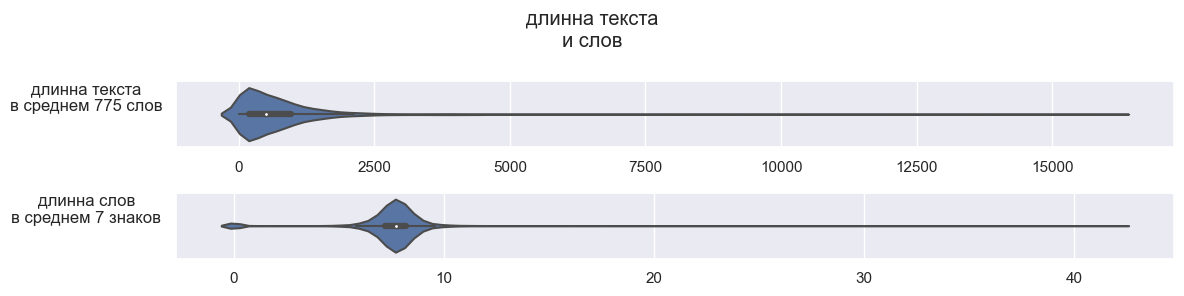

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 3))

plot_text_overview2_cols = ['len_text', 'mean_word_len']
plot_text_overview2_cols_rus = ['длинна текста\nв среднем {} слов', 'длинна слов\nв среднем {} знаков']
for position, column, xaxisname in zip([0,1],
                                    plot_text_overview2_cols,
                                    plot_text_overview2_cols_rus):    
    sns.violinplot(data, x=column, orient='h',
                ax=ax[position])
    local_mean = data[column].mean()
    plt.sca(ax[position])
    plt.xlabel('')
    plt.ylabel(xaxisname.format(int(local_mean)), rotation=0, labelpad=55)

plt.suptitle('длинна текста\nи слов')    
plt.tight_layout()
plt.show()
plt.close()

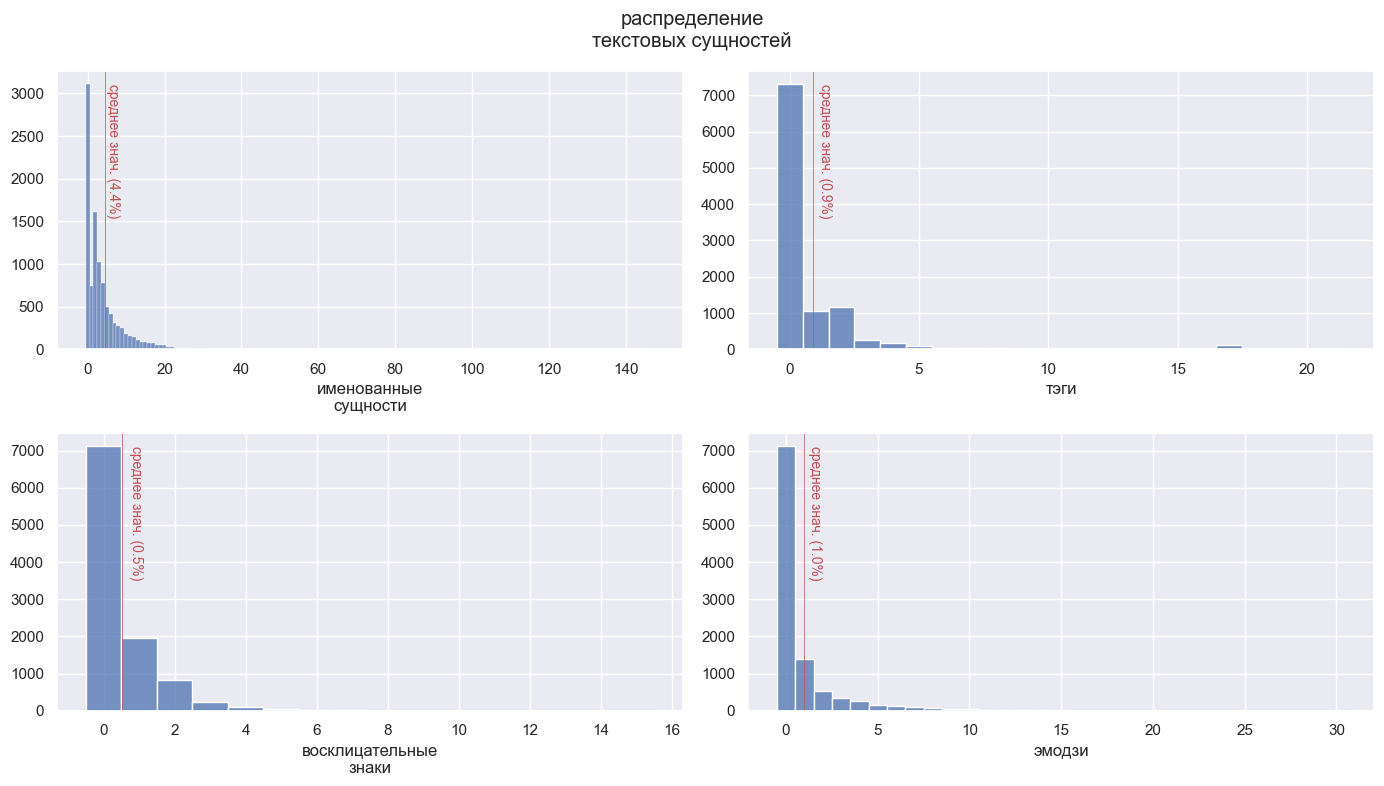

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

plot_text_overview1_cols = ['named_ent_count', 'tags_count',
                            'exclamations_count', 'emoji_count',
                           'mean_word_len', 'nouns', 'verbs', 'adjectives']
plot_text_overview1_cols_rus = ['именованные\nсущности', 'тэги', 'восклицательные\nзнаки', 'эмодзи',
                               'средняя длинна слов', 'существительные', 'глаголы', 'прилагательные']
for position, column, xaxisname in zip(itertools.product(range(2), range(2)),
                            plot_text_overview1_cols, plot_text_overview1_cols_rus):    
    sns.histplot(data, x=column, discrete=True,
                ax=ax[position])
    local_mean = data[column].mean()
    plt.sca(ax[position])
    plt.xlabel(xaxisname)
    plt.ylabel('')
    plt.axvline(local_mean, c='r', linewidth=0.5)
    plt.text(local_mean + 0.2,
             max([p.get_height() for p in ax[position].patches]),
         f'среднее знач. ({local_mean:.1f}%)',
         size='small',
         verticalalignment='top',
         c='r',
         rotation=-90)

plt.suptitle('распределение\nтекстовых сущностей')    
plt.tight_layout()
plt.show()
plt.close()

##### Тэги<a id="33"></a>

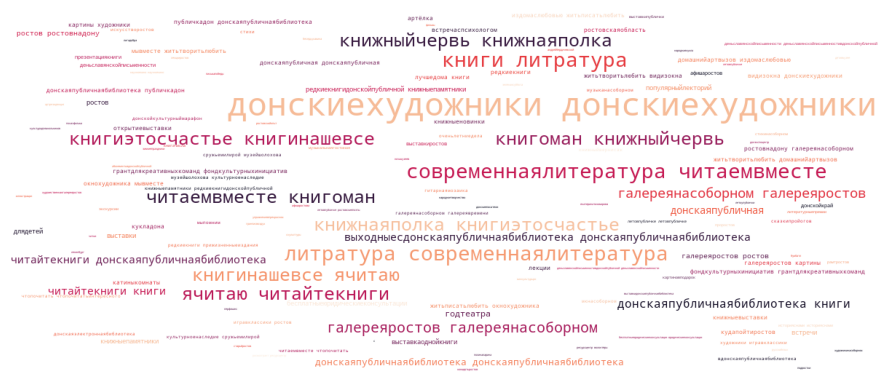

In [16]:
word_counting(data.loc[data['tags'] != '', 'tags'], plot_height=4,
              plot_widh=16, clowd_height=500, clowd_widh=1200, prefer_horizontal=1)

   


- [К оглавлению](#1) 

##### Другие признаки   <a id="34"></a>


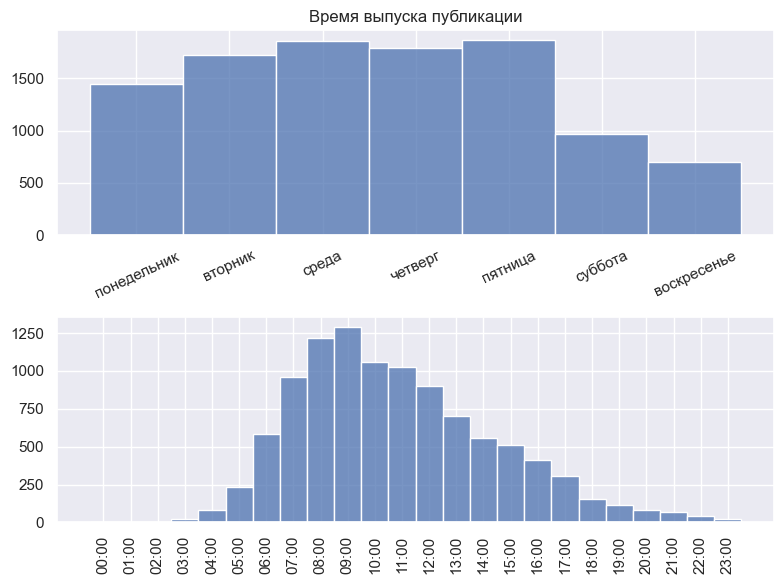

In [17]:
custom_day_of_week_calendar = {
                            0: 'понедельник',
                            1: 'вторник',
                            2: 'среда',    
                            3: 'четверг',
                            4: 'пятница',
                            5: 'суббота',
                            6: 'воскресенье'
                        }

data['hour'] = pd.to_datetime(data['hour'], format='%H').dt.strftime('%H:%M')
data['dayofweek'] = data['dayofweek'].replace(custom_day_of_week_calendar)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))

hist_dt_1 = sorted(data['dayofweek'].tolist(),
    key=lambda x: [i for i in custom_day_of_week_calendar.values()].index(x))

hist_dt_2 = data['hour'].sort_values()

for position, dt in zip(itertools.product(range(2)),
                            [hist_dt_1, hist_dt_2]):    
        
    sns.histplot(x=dt, ax=ax[position])
    plt.sca(ax[position])
    plt.ylabel('')
    plt.xlabel('')

plt.sca(ax[0])
plt.xticks(rotation=25)
plt.title('Время выпуска публикации')
plt.sca(ax[1])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.close()

На графике можно видеть распределение публикаций по времени в течение недели и суток. Время выхода публикации непосредственно вляет на просматриваемость постов.

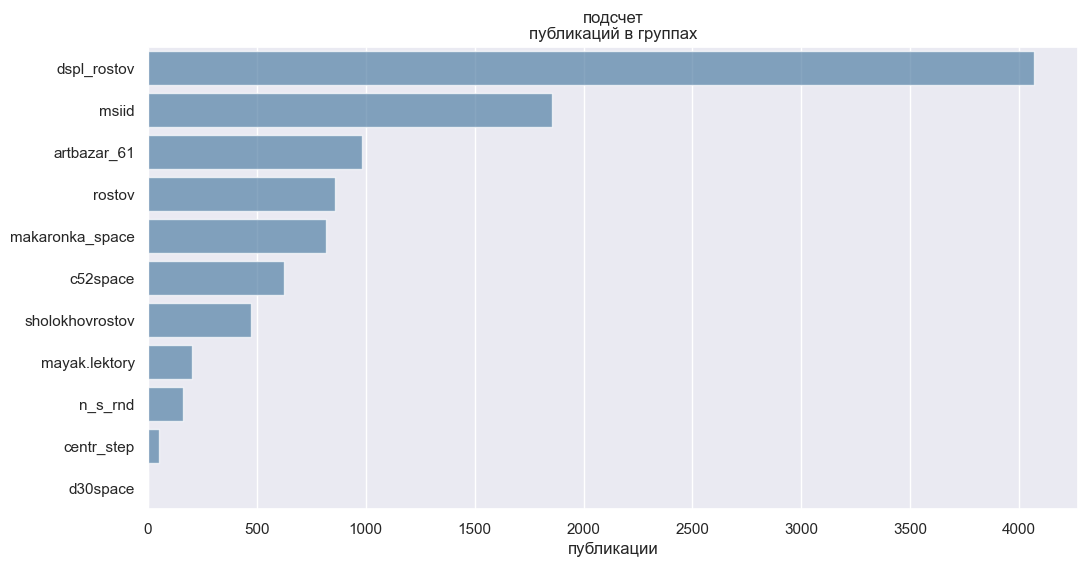

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_groups_count = (data.groupby('source_group', as_index=False)
                    .agg({'text': 'count'})
                    .rename(columns={'text': 'count'})
                    .sort_values('count', ascending=False))
sns.barplot(plot_groups_count,
            x='count',
            y='source_group',
            alpha=.7,
            color='steelblue')

plt.xlabel('публикации')
plt.ylabel('')
plt.title('подсчет\nпубликаций в группах')
plt.show()
plt.close()

Значительная часть публикаций (40%) сделана в группе "dspl_rostov".   


- [К оглавлению](#1) 

## Разработка модели<a id="4"></a>

In [19]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Показать / скрыть код"></form>''')

### Подготовка признаков<a id="41"></a>

In [20]:
# формирование признаков
features = data[['tok_without_names_unique',
                 'named_entities',
                 'tags',                 
                 'emoji_rate',
                 'exclamations_count',
                 'nouns',
                 'verbs',
                 'adjectives',
                 'mean_word_len',
                 'is_pinned',
                 'has_link',
                 'attachments',
                 'len_text',
                 'dayofweek',
                 'hour',
                 'named_ent_count',
                 'tags_count'
                 ]]

features_num_cols = ['emoji_rate', 'exclamations_count',
                 'nouns', 'verbs', 'adjectives', 'mean_word_len',
                 'attachments', 'len_text','named_ent_count', 'tags_count']
features_cat_cols = ['is_pinned', 'has_link', 'dayofweek', 'hour']
features_text_cols = ['tok_without_names_unique', 'named_entities', 'tags']

# формирование целевого признака
target = (data['likes'] / data['views']) * 100
target_std = np.std(target)

print("Признаки для обучения модели:")
display(features.head(3))
print()
print("Целевой признак:")
display(target.head(3))
print('Размерность пространства признаков:')
print(features.shape)

Признаки для обучения модели:


,tok_without_names_unique,named_entities,tags,emoji_rate,exclamations_count,nouns,verbs,adjectives,mean_word_len,is_pinned,has_link,attachments,len_text,dayofweek,hour,named_ent_count,tags_count
0,стена конкретный обсуждение дата найти датуафи...,,,0.000000,0,0.545455,0.272727,0.181818,8.5,1.0,1,1.0,167,четверг,11:00,0,0
1,чудо жанр ряд верба представить танец соавтор ...,,,0.000000,3,0.522124,0.115044,0.345133,7.7,0.0,0,1.0,1350,среда,10:00,5,0
2,концерт целиноградский билет купить февраль пе...,,,0.028986,0,0.750000,0.125000,0.125000,7.9,0.0,1,1.0,138,понедельник,13:00,2,0



Целевой признак:


0    0.380952
1    3.205128
2    0.537634
dtype: float64

Размерность пространства признаков:
(10355, 17)


17 признаков и 10355 наблюдений   


- [К оглавлению](#1) 

##### Корреляция признаков

interval columns not set, guessing: ['emoji_rate', 'exclamations_count', 'nouns', 'verbs', 'adjectives', 'mean_word_len', 'is_pinned', 'has_link', 'attachments', 'len_text', 'named_ent_count', 'tags_count', 'target']


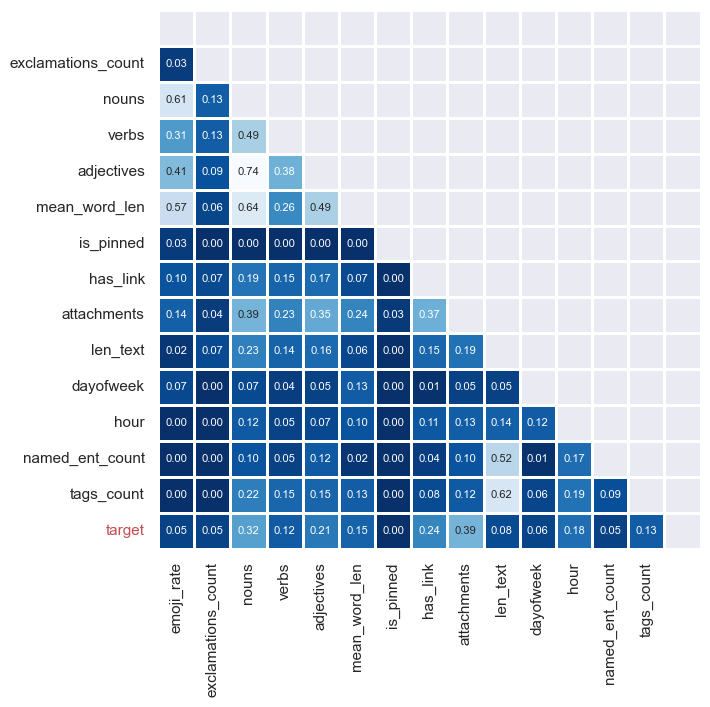

In [21]:
plt.figure(figsize=(7, 7))
corr = features.drop(['tok_without_names_unique',
                 'named_entities',
                 'tags'], axis=1).join(target.rename('target')).phik_matrix(dropna=False)
mask = np.triu(np.ones_like(corr, dtype='bool'))

ax = sns.heatmap(corr, linewidths=2, annot=True, mask=mask,
                 annot_kws={'size': 8}, fmt='.2f', cbar=False, cmap='Blues_r')

ax.yaxis.get_ticklabels()[-1].set_color('r')
ax.yaxis.get_ticklabels()[0].set_color('w')
ax.xaxis.get_ticklabels()[-1].set_color('w')

plt.xticks(rotation=90)
plt.show()
plt.close()

Выборка разделена на тренировочную и тестовую в соотношении 4 к 1. Валидационная выборка не требуется (предварительная проверка качества модели осуществляется методом кросс-валидации.   


- [К оглавлению](#1) 

In [22]:
# разделение на тренировочную и тестовую
X_train, X_test, y_train_likes, y_test_likes = train_test_split(features, target, test_size=.2, random_state=RS)
X_train['emoji_rate'] = X_train['emoji_rate'].fillna(0)
X_test['emoji_rate'] = X_test['emoji_rate'].fillna(0)

# -------- cut here -----------------------------------

# инициализация и применение тектового векторизатора для текста, тэгов и имен. сущностей
text_vectorizer = TfidfVectorizer(min_df=20, ngram_range=(1,2))
tags_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,1))
named_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,2))

X_train_text_vec = text_vectorizer.fit_transform(X_train['tok_without_names_unique'])
X_test_text_vec = text_vectorizer.transform(X_test['tok_without_names_unique'])
X_train_tags_vec = tags_vectorizer.fit_transform(X_train['tags'])
X_test_tags_vec = tags_vectorizer.transform(X_test['tags'])
X_train_named_vec = named_vectorizer.fit_transform(X_train['named_entities'])
X_test_named_vec = named_vectorizer.transform(X_test['named_entities'])

# -------- cut here -----------------------------------

# порядковое кодирование для категориальных признаков
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_enc = ordinal_enc.fit_transform(X_train[features_cat_cols])
X_test_enc = ordinal_enc.transform(X_test[features_cat_cols])

# "склеивание" признаков в матрицы Train и Test
X_train_likes = scipy.hstack((X_train_text_vec.toarray(),
                                X_train_tags_vec.toarray(),
                                X_train_named_vec.toarray(),
                                X_train[features_num_cols],
                                X_train_enc))
X_test_likes = scipy.hstack((X_test_text_vec.toarray(),
                               X_test_tags_vec.toarray(),
                               X_test_named_vec.toarray(),
                               X_test[features_num_cols],
                               X_test_enc))

# -------- cut here -----------------------------------

print("ГРУППЫ ПРИЗНАКОВ")
print(f"Основной текст:                       {X_train_text_vec.shape}  {X_test_text_vec.shape}")
print(f"Тэги:                                 {X_train_tags_vec.shape}    {X_test_tags_vec.shape}")
print(f"Именов. сущности:                     {X_train_named_vec.shape}   {X_test_named_vec.shape}")
print(f"Числовые признаки:                    {X_train[features_num_cols].shape}    {X_train[features_num_cols].shape}")
print(f"Другие признаки (Ordinal encoded):    {X_train_enc.shape}     {X_test_enc.shape}")
print()
print("ИТОГОВЫЕ НАБОРЫ ПРИЗНАКОВ")
print(f"Признаки (не массштабированы):        {X_train_likes.shape}  {X_test_likes.shape}")
print(f"Целевой признак:                      {y_train_likes.shape}       {y_test_likes.shape}") 

ГРУППЫ ПРИЗНАКОВ
Основной текст:                       (8284, 3834)  (2071, 3834)
Тэги:                                 (8284, 68)    (2071, 68)
Именов. сущности:                     (8284, 272)   (2071, 272)
Числовые признаки:                    (8284, 10)    (8284, 10)
Другие признаки (Ordinal encoded):    (8284, 4)     (2071, 4)

ИТОГОВЫЕ НАБОРЫ ПРИЗНАКОВ
Признаки (не массштабированы):        (8284, 4188)  (2071, 4188)
Целевой признак:                      (8284,)       (2071,)


In [45]:
# дополнительные данные для предсказания просмотров
views_base_cols = ['date',
                  'is_pinned',
                  'attachments',
                  'post_source',
                  'dayofweek',
                  'hour',
                  'source_group']
views_X_train = data.loc[X_train.index, views_base_cols]
views_X_test = data.loc[X_test.index, views_base_cols]
views_y_train = data.loc[y_train_likes.index, 'views']
views_y_test = data.loc[y_test_likes.index, 'views']

# сокращение отметок даты-времени
views_X_train['date'] = views_X_train['date'].dt.strftime("%d %m %Y")
views_X_test['date'] = views_X_test['date'].dt.strftime("%d %m %Y")

views_base_cols_cat = ['date',                      
                      'post_source',               
                      'source_group','dayofweek',
                      'hour','is_pinned']
views_base_cols_num = [
                      'attachments'
                      ]

# преобразование категориальных признаков для предсказания просмотров
ordinal_enc_views = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
views_X_train_enc = ordinal_enc_views.fit_transform(views_X_train[views_base_cols_cat])
views_X_test_enc = ordinal_enc_views.transform(views_X_test[views_base_cols_cat])

views_X_train = scipy.hstack((views_X_train_enc, views_X_train[views_base_cols_num]))
views_X_test = scipy.hstack((views_X_test_enc, views_X_test[views_base_cols_num]))

# -------- cut here -----------------------------------

# # Optuna LightGBM gridsearch
# # метод использован на этапе первичной подготовки модели
# def objective_LGBMRegressor(trial):
#     num_leaves = trial.suggest_int('num_leaves', low=30, high=80)
#     learning_rate = trial.suggest_float('learning_rate', low=0.05, high=0.2, log=True)    
#     max_depth = trial.suggest_int(name = 'max_depth', low = 30, high = 60)    
#     reg_lambda = trial.suggest_int(name = 'reg_lambda', low = 30, high = 45)
#     n_estimators = trial.suggest_int(name = 'n_estimators', low = 90, high = 150, step=1)

#     LGBM_Regressor = LGBMRegressor(
#                         num_leaves=num_leaves,
#                         learning_rate=learning_rate,
#                         objective='regression',
#                         metric='rmse',
#                         max_depth=max_depth,
#                         reg_lambda=reg_lambda,
#                         n_estimators=n_estimators,                        
#                         random_state=RS,
#                         verbose=-1)

#     score = cross_val_score(LGBM_Regressor,
#                             views_X_train, views_y_train,
#                             scoring='neg_root_mean_squared_error',
#                             cv=4, error_score='raise'
#                                                    ).mean()
#     return score

# ############ split here

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study = optuna.create_study(direction='maximize', pruner=MedianPruner())

# with tqdm(total=150) as pbar:
#     def callback(study, trial):
#         pbar.update(1)
#     study.optimize(objective_LGBMRegressor,
#                    n_trials=150,
#                    callbacks=[callback])

# ############ split here

# fig = plot_optimization_history(study)
# # fig.update_layout(yaxis_range=[0.475,0.483])
# fig.show()

# print(study.best_value)
# print(study.best_params)

# -------- cut here -----------------------------------

# полученный optuna RMSE модели
LGBM_best_RMSE = 1.179987677094565

# гиперпараметры для обучения основнйо модели
LGBM_params = {'num_leaves': 68,
                    'learning_rate': 0.058,
                    'max_depth': 39,
                    'reg_lambda': 34,
                    'n_estimators': 137}

# гиперпараметры для предсказания просмотров
views_LGBM_params = {'num_leaves': 30,
                     'learning_rate': 0.052,
                     'max_depth': 40,
                     'reg_lambda': 45,
                     'n_estimators': 91}

# обучение моделей
LGBM_Regressor = LGBMRegressor(**LGBM_params,
                        random_state=RS,
                        verbose=-1)

views_LGBM_Regressor = LGBMRegressor(**views_LGBM_params,
                        random_state=RS,
                        verbose=-1)

**Модель для предсказания конверсии просмотров в лайки**<a id="42"></a>

In [50]:
LGBM_Regressor.fit(X_train_likes, y_train_likes)

LGBMRegressor(learning_rate=0.058, max_depth=39, n_estimators=137,
              num_leaves=68, random_state=1008, reg_lambda=34, verbose=-1)

**Модель для предсказания кол-ва просмотров** (вспомогательная)

In [46]:
views_LGBM_Regressor.fit(views_X_train, views_y_train)

LGBMRegressor(learning_rate=0.052, max_depth=40, n_estimators=91, num_leaves=30,
              random_state=1008, reg_lambda=45, verbose=-1)

In [53]:
# import joblib

# сохранение трансформеров
# joblib.dump(text_vectorizer, 'text_vectorizer.joblib')
# joblib.dump(tags_vectorizer, 'tags_vectorizer.joblib')
# joblib.dump(named_vectorizer, 'named_vectorizer.joblib')
# joblib.dump(ordinal_enc, 'ordinal_enc.joblib')
# joblib.dump(ordinal_enc_views, 'ordinal_enc_views.joblib')

# сохранение моделей
# booster1 = LGBM_Regressor.booster_
# booster1.save_model('LGBM_Regressor.txt')
# booster2 = views_LGBM_Regressor.booster_
# booster2.save_model('views_LGBM_Regressor.txt')
# booster = lgb.Booster(model_file='LGBM_Regressor.txt')

#### Проверка качества модели
Предварительная проверка качества модели проводится методом кросс-валидации.
- RMSE - показывает на сколько в среднем отклоняется предсказание модели от реальных значений конверсии (конверсия в лайки выражена в процентах). 
- R2 - коэффициент детерминации, показывает качество модели (чем ближе к 1.0 тем точнее модель предсказывает показания, 0.0 - модель идентична простому среднему значнению, ниже 0.0 - модель работает хуже предсказания по среднему знач.)

In [27]:
RMSE_cross_val = -cross_val_score(LGBM_Regressor, X_train_likes, y_train_likes, scoring='neg_root_mean_squared_error').mean()
R2_cross_val = cross_val_score(LGBM_Regressor, X_train_likes, y_train_likes, scoring='r2').mean()

print("Кроссвалидация конверсии лайков в просмотры (целевого признака) на тренировчной выборке.")
print(f"RMSE: {RMSE_cross_val:.2f} при стандартном отклонении {np.std(y_train_likes):.2f}"
      f" ({RMSE_cross_val / np.std(y_train_likes):.2f} отклонения)")
print(f"R2: {R2_cross_val:.2f}")

Кроссвалидация конверсии лайков в просмотры (целевого признака) на тренировчной выборке.
RMSE: 1.16 при стандартном отклонении 1.59 (0.73 отклонения)
R2: 0.47


In [28]:
RMSE_cross_val_views = -cross_val_score(views_LGBM_Regressor,
                                        views_X_train,
                                        views_y_train,
                                        scoring='neg_root_mean_squared_error').mean()
R2_cross_val_views = cross_val_score(views_LGBM_Regressor,
                                     views_X_train,
                                     views_y_train, scoring='r2').mean()

print("Кроссвалидация количества просмотров (вторичного таргета) на тренировчной выборке")
print(f"RMSE: {RMSE_cross_val_views:.2f} при стандартном отклонении {np.std(views_y_train):.2f}"
      f" ({RMSE_cross_val_views / np.std(views_y_train):.2f} отклонения)")
print(f"R2: {R2_cross_val_views:.2f}")

Кроссвалидация количества просмотров (вторичного таргета) на тренировчной выборке
RMSE: 870.60 при стандартном отклонении 1126.11 (0.77 отклонения)
R2: 0.36


   


- [К оглавлению](#1) 

### Проверка на тестовой выборке<a id="43"></a>

In [29]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Показать / скрыть код"></form>''')

In [30]:
test_predict = LGBM_Regressor.predict(X_test_likes)

RMSE_test = np.sqrt(mean_squared_error(y_test_likes, test_predict))
RMSE_test_mean = np.sqrt(mean_squared_error(y_test_likes, [np.mean(y_test_likes) for _ in range(len(y_test_likes))]))
R2_test = r2_score(y_test_likes, test_predict)

print("Проверка на тестовой выборке")
print(f"RMSE: {RMSE_test:.2f} при стандартном отклонении {np.std(y_test_likes):.2f}"
      f" ({RMSE_test / np.std(y_test_likes):.2f} отклонения)")
print(f"RMSE dummy-регрессора (среднее значение): {RMSE_test_mean:.2f}")
print(f"R2: {R2_test:.2f}")

Проверка на тестовой выборке
RMSE: 1.11 при стандартном отклонении 1.56 (0.71 отклонения)
RMSE dummy-регрессора (среднее значение): 1.56
R2: 0.50


Модель показывает удовлетворительный результат. RMSE составляет 1.13, что меньше одного стандартного отклонения для конверсии просмтров в лайки, и меньше предсказания по простому среднему значению конверсии.   
R2 модели на тестовой выборке также выше $0$.

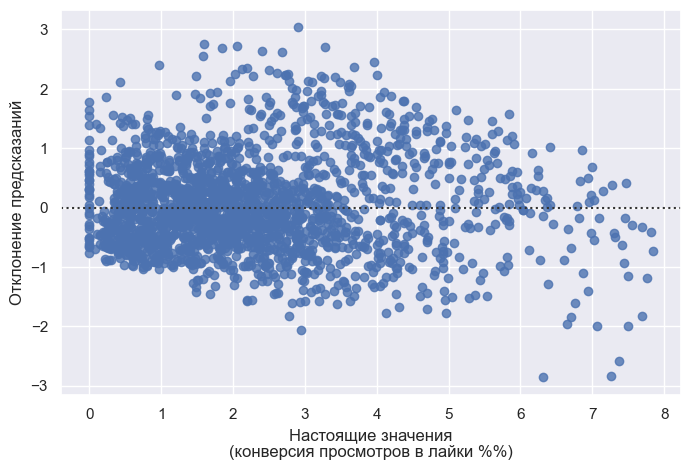

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.residplot(x=y_test_likes, y=test_predict, robust=True, )
plt.xlabel('Настоящие значения\n(конверсия просмотров в лайки %%)')
plt.ylabel('Отклонение предсказаний')
plt.show()
plt.close()

Модель имеет склонность к некоторому занижению конверсии.

In [32]:
# вычисление среднего количества реальных лайков за 2 мес (без группировки по источникам публикаций)
views_mean = data[data['date'] > (data['date'].max() - pd.to_timedelta(60, unit='D'))]['views'].mean()
views_mean_hardcode = 889

# функция для предсказания лайков (на основе предсказанных просмотров,
#                                 среднего, а также заданного пользователем значения)
def likes_prediction(views_type='predict', views=views_mean_hardcode):
    if views_type == 'predict':
        views_count = views_LGBM_Regressor.predict(views_X_test)
    elif views_type == 'mean':
        views_count = [views_mean_hardcode for _ in range(len(views_y_test))]
    elif views_type == 'imperative':
        views_count = [views for _ in range(len(views_y_test))]
    else:
        print('wrong views output type')
        pass

    output_df = pd.DataFrame({'views': views_count, 'popularity': test_predict}, index=X_test.index)
    return round(output_df['views'] * output_df['popularity'] / 100).astype('int')

likes_test_prediction = pd.DataFrame({'real likes': data.loc[X_test.index, 'likes'],
                                      'predicted likes': likes_prediction('predict')})

RMSE_test_final_likes = np.sqrt(mean_squared_error(likes_test_prediction['real likes'],
                                                   likes_test_prediction['predicted likes']))
R2_test_final_likes = r2_score(likes_test_prediction['real likes'],
                               likes_test_prediction['predicted likes'])

print("Проверка на тестовой выборке")
print(f"RMSE: {RMSE_test_final_likes:.2f} при стандартном отклонении {np.std(likes_test_prediction['real likes']):.2f}"
      f" ({RMSE_test_final_likes / np.std(likes_test_prediction['real likes']):.2f} отклонения)")
print(f"R2: {R2_test_final_likes:.2f}")

Проверка на тестовой выборке
RMSE: 11.80 при стандартном отклонении 17.13 (0.69 отклонения)
R2: 0.53


Предсказание количества лайков также демонстрирует удовлетворительное качество. Однако, важно помнить, что эта метрика основа на предсказании числа просмотров, которое в больше степени подвережено сезонности, и связано с источником публикации.   


- [К оглавлению](#1) 

## Важность признаков<a id="5"></a>

In [33]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Показать / скрыть код"></form>''')

##### Текст<a id="51"></a>

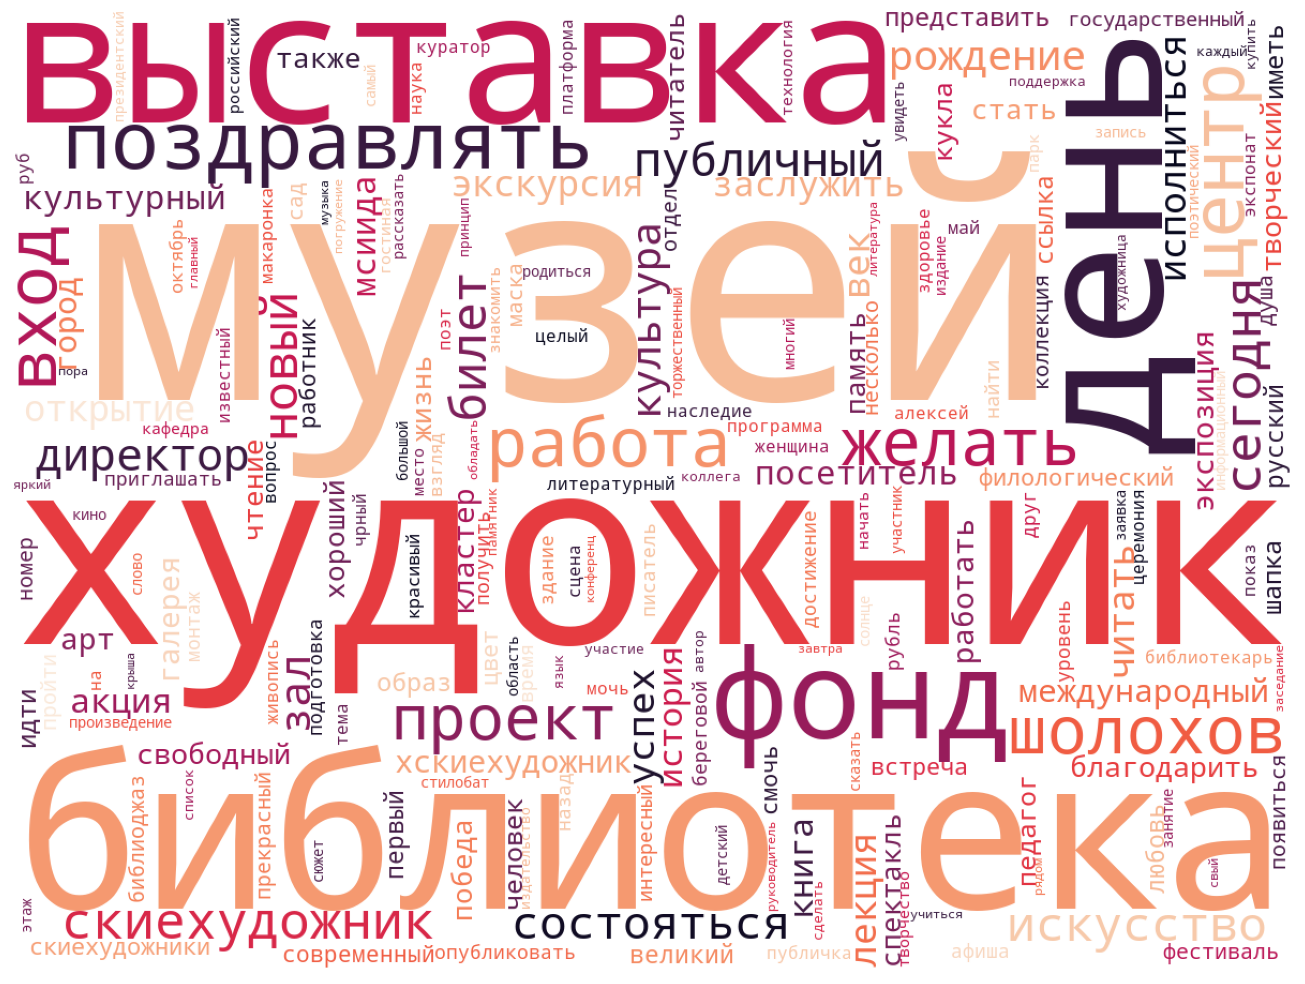

In [34]:
all_features_names_out = []
all_features_names_out.extend(text_vectorizer.get_feature_names())
all_features_names_out.extend(tags_vectorizer.get_feature_names())
all_features_names_out.extend(named_vectorizer.get_feature_names())
all_features_names_out.extend(features_num_cols)
all_features_names_out.extend(ordinal_enc.get_feature_names_out().tolist())

# -------- cut here -----------------------------------

datatype = []
datatype.extend(['text' for i in text_vectorizer.get_feature_names()])
datatype.extend(['tags' for i in tags_vectorizer.get_feature_names()])
datatype.extend(['named_ent' for i in named_vectorizer.get_feature_names()])
datatype.extend(['other' for i in features_num_cols])
datatype.extend(['other' for i in ordinal_enc.get_feature_names_out().tolist()])

importances_df = pd.DataFrame({'type_of_data': datatype,
                                'features': all_features_names_out,
                                   'importances': LGBM_Regressor.feature_importances_})

# -------- cut here -----------------------------------

def wordclowd_words_agg(data_category='text'):
    stage_0 = (importances_df[importances_df['type_of_data'] == data_category]
                             .apply(lambda x: [x['features'] for i in range(x['importances'])], axis=1)
                            )
    stage_1 = re.sub("[ ]{2,}", ' ',
                                   ' '.join(stage_0
                                            .apply(lambda x: ' '.join(x)).tolist())
                                  )
    stage_2 = stage_1.split()
    random.shuffle(stage_2)
    return ' '.join(stage_2)

# -------- cut here -----------------------------------

word_counting(data_string=wordclowd_words_agg(), prefer_horizontal=.2)

Анализ важности текстовых признаков в большей степени даёт понимание тем, которые находят отзыв у подписчиков, нежели способа подачи информации. 

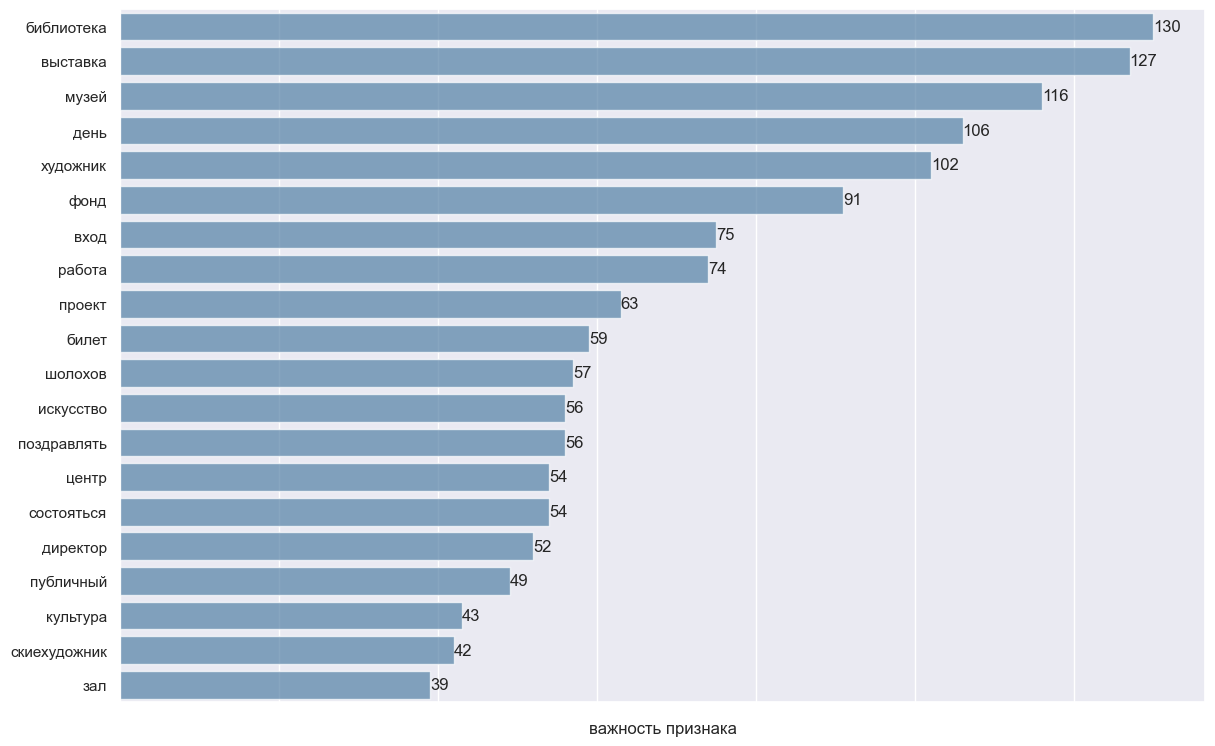

In [35]:
def words_bar_plot(type_of_data, n_bars=25, height=12):
    
    """
    type_of_data=[list]
    """
    
    fig, ax = plt.subplots(figsize=(14, height))

    all_words_plot = (
        importances_df
            .loc[importances_df['type_of_data'].isin(type_of_data)]
            .sort_values('importances', ascending=False).head(n_bars)
            )

    sns.barplot(all_words_plot,
                x='importances',
                y='features',
                alpha=.7,
                color='steelblue'
               )
    plt.bar_label(ax.containers[0])
    ax.set(xticklabels=[])
    plt.xlabel('важность признака')
    plt.ylabel('')
    plt.show()
    plt.close()

words_bar_plot(['text', 'tags', 'named_ent'], n_bars=20, height=9)

<p>
    <div class="pull-left">
        <img title="shap values for text" alt="" src="https://raw.githubusercontent.com/eilyich/WorkshopNLP_streamlit/master/shap_text_summary3.png" width="600">
        </div>
        Некоторые сущности (слова), как то "стать", "день", "друг", "работа" существенно влияют на предсказание модели, однако интерпретировать их без контекста не представляется возможным.   
Такие сущности как "выставка", "музей", "фонд", "художник", "библиотека" дают понимание, что интересует публику.   

Однако не все эти сущности в тексте обязательно повышают популярность публикаций. Некоторые, влияют на неё негативно.


◄ Как именно текстовые признаки влияют на целевой иллюстрирует график слева.  
<span style="color: red;">Красным</span> выделены высокие значения признака (в случае с текстом это $1$ - значит слово есть в публикации). <span style="color: blue;">Синим</span> выделены низкие значения признака ($0$ - слова нет в тексте).
Значения в левой части графика - то, что понижает предсказание (меньше лайков), в правой части графика - то, что повышает.

Видно, что когда речь о музеях, фондах, выставках, пользователи действительно охотней отмечают эти публикации. 
Положительный интерес вызывают также упоминания библиотеки, художников, экскурсий, открытий (вероятно, каких-либо мероприятий).  

В то же время, такие сущности как "билет", "вход", "вопрос", "новый" - влияют негативно на популярность. Важно отметить: не стоит воспринимать такие понятия как отпугивающие - они лишь вносят вклад в общее восприятие и реакцию пользователей.  

Окончательная интерпретация значимости этих сущностей - в ведении авторов и редакторов публикаций.   

Именованные сущности также влияют не предсказание модели, однако интерпретировать их не представляется возможным, так как в большинстве случаев это имена лидей и топонимы - популярность постов с их упоминанием зависит от контекста.

</p>  

   


- [К оглавлению](#1) 

##### Тэги<a id="52"></a>
Отдельной текстовой категорией являются тэги, которые сопровождают большинство постов. Однако, заметный вклад в популярность постов вносят лишь некоторые: 

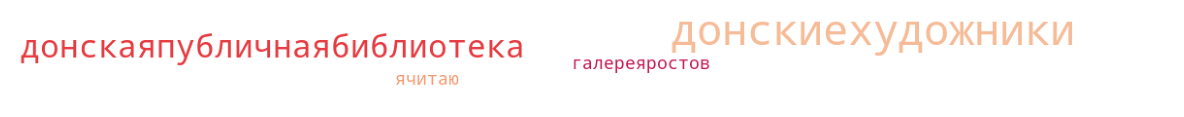

In [36]:
word_counting(data_string=wordclowd_words_agg('tags'), prefer_horizontal=1,plot_widh=12, plot_height=2,clowd_widh=1200,
    clowd_height=100)

⋆ *тэг "донскаяпубличнаябиблиотека" в данном случае является сводным - в текстах он встречается во множестве разных вариаций написания.*

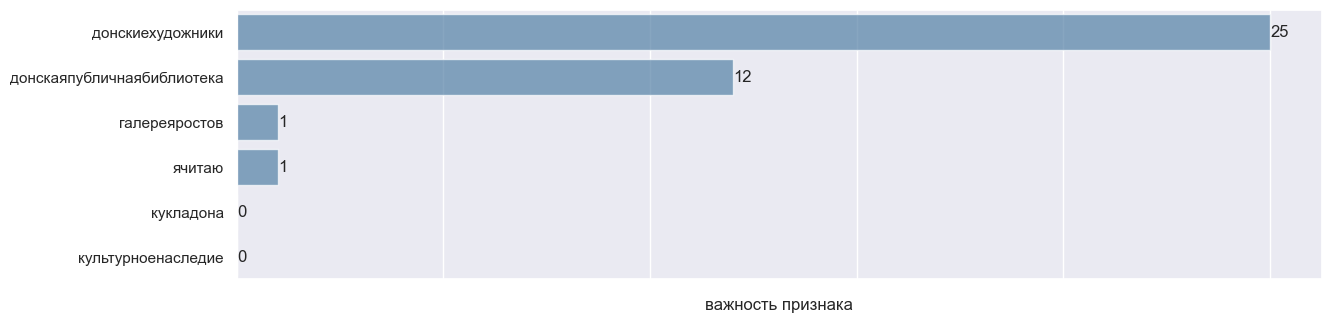

In [37]:
words_bar_plot(['tags'], n_bars=6, height=3.5)

   


- [К оглавлению](#1) 

##### Другие признаки<a id="53"></a>
НЕтекстовые признаки в большей степени демонстрируют то **как** а **не о чём** должен быть написан текст, чтобы понравиться читателям.

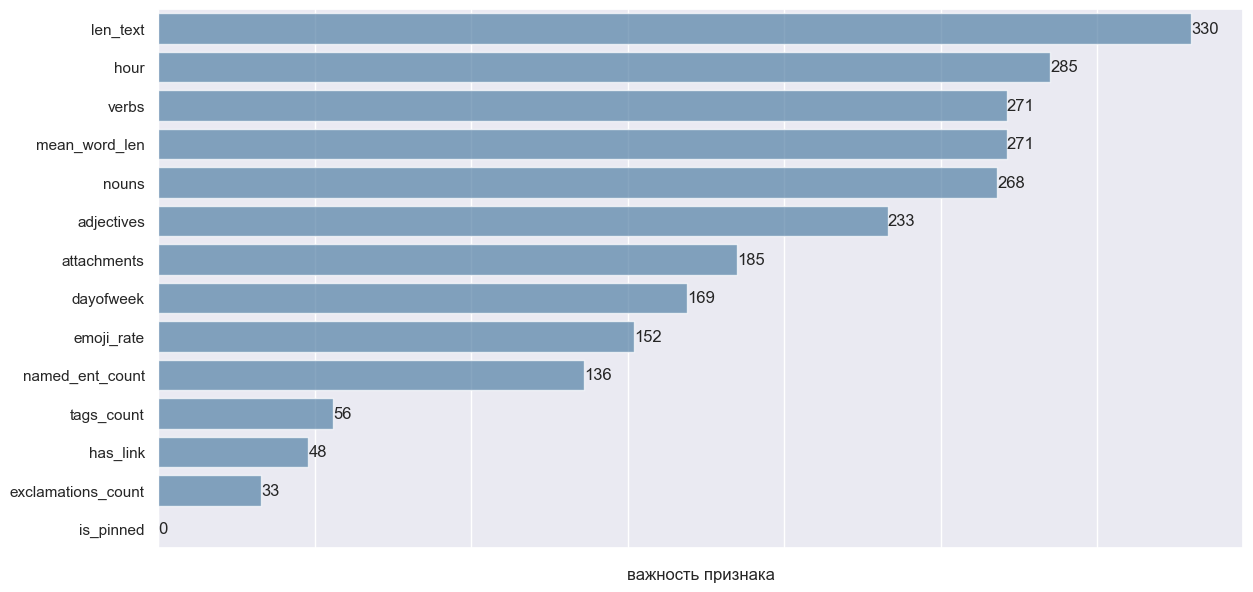

In [38]:
words_bar_plot(['other'], n_bars=15, height=7)

<p>
    <div class="pull-left">
        <img title="shap values for other features" alt="" src="https://raw.githubusercontent.com/eilyich/WorkshopNLP_streamlit/master/shap_other_summary3.png" width="600">
        </div>
Хорошо видно, что короткие, лаконичные тексты пользуются большей популярностью среди пользователей.    


Также положительно на количестве лайков сказывается отсутствие или минимальное количество эмодзи (вероятно, это малоприемлемо именно в культурной повестке).   

Популярность постов повышает наличие тэгов, однако важно, чтобы их не было слишком много. На графике слева можно наблюдать, что зона с ярко-красными точками (большое количество тэгов) находится примерно посередине диаграммы, в то время как в правой части "зоны повышения" - более тёмная область (небольшое количество тэгов).   

Вложения также, потенциально, повышают популярность публикаций. Впрочем, большинство наблюдений лежит не в зоне роста или убывания популярности, а посередине, из чего можно сделать вывод, что влияние этого параметра не критично. Кроме того, без сомнения, популярность публикации в значительнйо степени зависит от того какое именно вложение/вложения есть в посте. Именно по этой причине в датаесете для анализа были оставлены публикации без текста - фотография, или альбом фотографий, к примеру на художественную тематику, могут привлечь гораздо больше внимания.
 
Что касается самой манеры написания текстов: невозможно однозначно интерпретировать влияние средней длинны слов на популярность. Бóльшая доля существительных положительно влияет на количество лайков - можно это интерпретировать, как склонность пользователей к получению конкретики. Сделать такого же однозначного вывода о долях глаголов и прилагательных в тексте невозможно: влияние есть, но оно незначительное.

Для достижения повышения конверсии просмотров в лайки также можно ориентирваться на подходящее время публикации. Видно, что посты опубликованные в понедельник и в середине недели в среднем популярнее. Также больше поддержки получают тексты, опубликованные утром/в первой половине дня. 
</p>

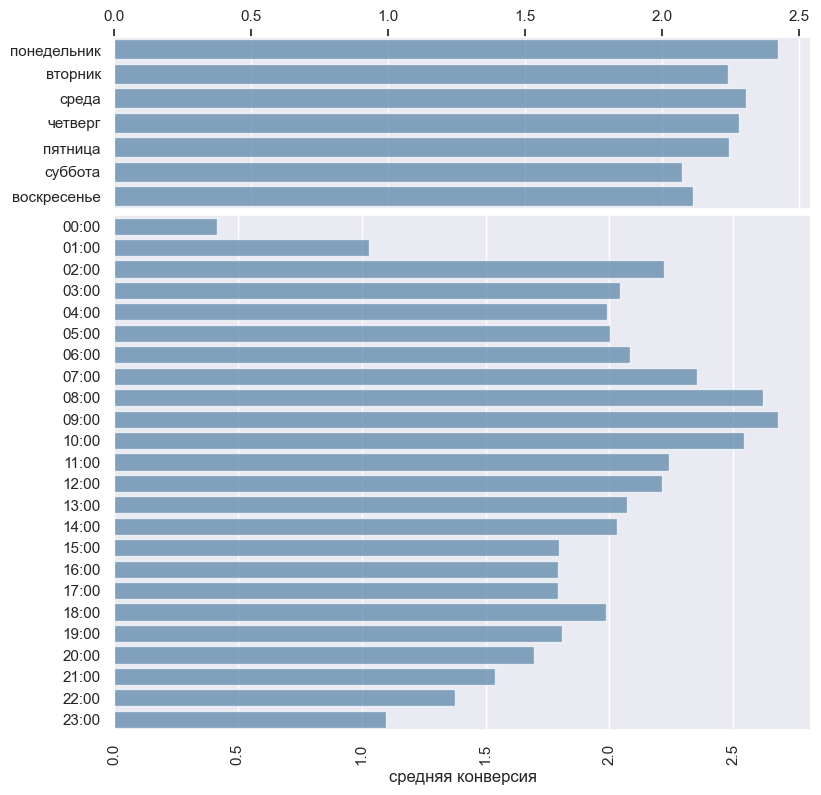

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(9, 9), gridspec_kw={'height_ratios': [1, 3]})

week_local_data =(pd.DataFrame({'dayofweek': features['dayofweek'],
                          'target': target})
                         .groupby('dayofweek', as_index=False)
                         .agg({'target': 'mean'})
                        )
week_local_data['dayofweek'] = pd.Categorical(week_local_data['dayofweek'],
                                              categories=custom_day_of_week_calendar.values(),
                                              ordered=True)
week_local_data = week_local_data.sort_values('dayofweek')
hour_local_data = (pd.DataFrame({'hour': features['hour'],
                          'target': target})
                         .groupby('hour', as_index=False)
                         .agg({'target': 'mean'})
                        )

sns.barplot(week_local_data,
            y='dayofweek',
            x='target',
            alpha=.7,
            color='steelblue',
            ax=ax[0])

sns.barplot(hour_local_data,
            y='hour',
            x='target',
            alpha=.7,
            color='steelblue',
            ax=ax[1])

ax[0].xaxis.tick_top()
plt.sca(ax[0])
plt.xlabel('')
plt.ylabel('')
plt.sca(ax[1])
plt.ylabel('')
plt.xlabel('средняя конверсия')
plt.xticks(rotation=90)
plt.subplots_adjust(hspace = 0.02)
plt.show()
plt.close()

## Выводы<a id="6"></a>

В целом при формировании публикаций следует руководствоваться стандартными правилами написания тектов - публицистических, если речь об описании событий, или маркетинговых, если речь о продвижении. Писать "по сути" (выше доля существительных), сжато (в разумных пределах - меньше длинна текста, средняя длинна слов), не злоупотреблять эмодзи, для наиболее важных постов выбирать время публикации в первой половине дня.   


- [К оглавлению](#1) 